In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler
#from sklearn.preprocessing import MinMaxScaler ##########

sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/media/controlslab/DATA/Projects')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Grid import GridDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#global variables

#deltas = [0.1, 0.1]
deltas = [10**(-1), 10**(-1)]

k = 1
c = 0.1
D = 1
num_fevals = 5

sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

def tf_model(X):
    
    l2_lambda_regularization = 0.20
    l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), 
                         name="fc1")
    A2 = tf.layers.dense(A1, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc2")
    y = tf.layers.dense(A2, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="out")
    
    return y


def tf_ghazale(X):
    
    l2_lambda_regularization = 0.1
    #l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 500, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         name="fc1")
    A2 = tf.layers.dense(A1, 100, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda_regularization), 
                         name="fc2")
    A3 = tf.layers.dense(A2, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda_regularization), 
                         name="fc3")
    y = tf.layers.dense(A3, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda_regularization), name="out")
    
    return y



def tf_model_yulin(X):
    
    A1 = tf.layers.dense(X, 32, activation=tf.nn.tanh, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),name="fc1")
    """
    dropout1 = tf.layers.dropout(inputs = A1, rate = 0.2)
    A2 = tf.layers.dense(A1, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc2")
    dropout2 = tf.layers.dropout(inputs = A2, rate = 0.2)
    A3 = tf.layers.dense(A2, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc3")
    dropout3 = tf.layers.dropout(inputs = A3, rate = 0.2)
    A4 = tf.layers.dense(A3, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc4")
    dropout4 = tf.layers.dropout(inputs = A4, rate = 0.2)
    """
    y = tf.layers.dense(A1, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    #activation funcs
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape, num_fevals=1, num_conditions=0, alpha=1):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)

    #y_pred = tf_model(X)
    #y_pred = tf_model_yulin(X)
    y_pred = tf_ghazale(X)
    
    #loss_function = loss_functions.squared_residual_function_wrapper2(k, c, D, deltas, num_fevals)
    loss_function =  loss_functions.linear_residual_function_wrapper(num_features, output_shape, 
                                                                     deltas, num_fevals, num_conditions, alpha)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.8).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

### Create Tunable Model Tensorflow and assign data

In [5]:
"""

#scaler = MinMaxScaler()

dhandler_stochastic = OscillatorDataHandler()

#(data_scaler = scaler)

model = tf_compiled_model(2, 1, 5)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_stochastic)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, x=[0, 0], boundaries=[10, 10], n=[50, 50])

#Real phi function
p_real_test, phi_real_test = analytic_functions.real_p(tModel.X_test[:,0], tModel.X_test[:,1], sigma_x, sigma_y)
p_real_train, phi_real_train = analytic_functions.real_p(tModel.X_train[:,0], tModel.X_train[:,1], sigma_x, sigma_y)
p_real_crossVal, phi_real_crossVal = analytic_functions.real_p(tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], sigma_x, sigma_y)

tModel.y_test = phi_real_test
tModel.y_train = phi_real_train
tModel.y_crossVal = phi_real_crossVal


tModel.print_data()
"""

"\n\n#scaler = MinMaxScaler()\n\ndhandler_stochastic = OscillatorDataHandler()\n\n#(data_scaler = scaler)\n\nmodel = tf_compiled_model(2, 1, 5)\n\ntModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', \n                                        data_handler=dhandler_stochastic)\n\ntModel.load_data(verbose=1, cross_validation_ratio=0.2, x=[0, 0], boundaries=[10, 10], n=[50, 50])\n\n#Real phi function\np_real_test, phi_real_test = analytic_functions.real_p(tModel.X_test[:,0], tModel.X_test[:,1], sigma_x, sigma_y)\np_real_train, phi_real_train = analytic_functions.real_p(tModel.X_train[:,0], tModel.X_train[:,1], sigma_x, sigma_y)\np_real_crossVal, phi_real_crossVal = analytic_functions.real_p(tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], sigma_x, sigma_y)\n\ntModel.y_test = phi_real_test\ntModel.y_train = phi_real_train\ntModel.y_crossVal = phi_real_crossVal\n\n\ntModel.print_data()\n"

## For linear PDE

In [6]:
#scaler = MinMaxScaler()

dhandler_grid = GridDataHandler()

#(data_scaler = scaler)

model = tf_compiled_model(num_features=2, output_shape=1, num_fevals=5, num_conditions=2, alpha=1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_grid, batch_size=8)

#tModel.load_data(verbose=1, cross_validation_ratio=0.2, x=0, boundaries=1, n=1000)
tModel.load_data(verbose=1, cross_validation_ratio=0.2, boundaries=[[0, 1], [0, 1]], n=[10, 10])

#Real phi function
tModel.y_test = analytic_functions.real_y(tModel.X_test[:,0])
tModel.y_train = analytic_functions.real_y(tModel.X_train[:,0])
tModel.y_crossVal = analytic_functions.real_y(tModel.X_crossVal[:,0])

tModel.print_data()

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

Loading data for the first time
Reloading data due to parameter change
Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(72, 2)
(72, 1)
Cross-Validation data (X, y)
(18, 2

/Users/davidlaredorazo/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [7]:
tModel.epochs = 200
#lrate = LearningRateScheduler(aux_functions.step_decay)
minibatches_function_handle = aux_functions_stochastic.get_minibatches

#tf.get_variable("deltas", initializer=deltas)

sess = tf.Session()

initial_xs = np.array([[0, 0], [1, 0]])
initial_ys = np.array([[1], [0]])

#writer = tf.summary.FileWriter('./graphs', sess.graph)

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas, initial_xs=initial_xs, initial_ys=initial_ys)

    # cost_reg: total_cost -> e
    # cost: R

[0.1, 0.1]
Epoch: 0001 cost_reg= 36.040526430 cost= 36.040526430
Epoch: 0002 cost_reg= 2.103973071 cost= 2.103973071
Epoch: 0003 cost_reg= 2.156107889 cost= 2.156107889
Epoch: 0004 cost_reg= 1.852150096 cost= 1.852150096
Epoch: 0005 cost_reg= 1.897003280 cost= 1.897003280
Epoch: 0006 cost_reg= 1.732445372 cost= 1.732445372
Epoch: 0007 cost_reg= 1.647745424 cost= 1.647745424
Epoch: 0008 cost_reg= 1.774973677 cost= 1.774973677
Epoch: 0009 cost_reg= 1.693703532 cost= 1.693703532
Epoch: 0010 cost_reg= 1.692838788 cost= 1.692838788
Epoch: 0011 cost_reg= 1.560996327 cost= 1.560996327
Epoch: 0012 cost_reg= 1.423035767 cost= 1.423035767
Epoch: 0013 cost_reg= 1.547522409 cost= 1.547522409
Epoch: 0014 cost_reg= 1.377455632 cost= 1.377455632
Epoch: 0015 cost_reg= 1.700630373 cost= 1.700630373
Epoch: 0016 cost_reg= 1.665365087 cost= 1.665365087
Epoch: 0017 cost_reg= 1.520120541 cost= 1.520120541
Epoch: 0018 cost_reg= 1.445630160 cost= 1.445630160
Epoch: 0019 cost_reg= 1.458701962 cost= 1.458701962

Epoch: 0162 cost_reg= 1.464073201 cost= 1.464073201
Epoch: 0163 cost_reg= 1.670724458 cost= 1.670724458
Epoch: 0164 cost_reg= 1.520351417 cost= 1.520351417
Epoch: 0165 cost_reg= 1.378677673 cost= 1.378677673
Epoch: 0166 cost_reg= 1.917906192 cost= 1.917906192
Epoch: 0167 cost_reg= 1.577776074 cost= 1.577776074
Epoch: 0168 cost_reg= 1.798118247 cost= 1.798118247
Epoch: 0169 cost_reg= 1.494052708 cost= 1.494052708
Epoch: 0170 cost_reg= 1.423802853 cost= 1.423802853
Epoch: 0171 cost_reg= 1.287847582 cost= 1.287847582
Epoch: 0172 cost_reg= 1.446808259 cost= 1.446808259
Epoch: 0173 cost_reg= 1.559572346 cost= 1.559572346
Epoch: 0174 cost_reg= 1.290132576 cost= 1.290132576
Epoch: 0175 cost_reg= 1.359134701 cost= 1.359134701
Epoch: 0176 cost_reg= 1.627607663 cost= 1.627607663
Epoch: 0177 cost_reg= 1.284900834 cost= 1.284900834
Epoch: 0178 cost_reg= 1.457811879 cost= 1.457811879
Epoch: 0179 cost_reg= 1.384138452 cost= 1.384138452
Epoch: 0180 cost_reg= 1.209733069 cost= 1.209733069
Epoch: 0181 

In [8]:
display_points = 20

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
y_pred = tModel.y_predicted
y_real = tModel.y_crossVal
print("scores")

print(X_test)
print(y_real)

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(y_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)
print(sample_points)

y_real_sampled = y_real[sample_points]
y_pred_sampled = y_pred[sample_points]
X_sampled = X_test[sample_points,:]

print(y_real_sampled)

i = range(len(y_pred_sampled))


for x, y_real_display, y_pred_display in zip(X_sampled, y_real_sampled, y_pred_sampled):
    print('x {}, Real y {}, Predicted y {}'.format(x, y_real_display, y_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
[[0.55555556 0.77777778]
 [0.22222222 0.11111111]
 [0.22222222 0.44444444]
 [0.66666667 0.22222222]
 [0.44444444 0.77777778]
 [0.22222222 1.        ]
 [0.33333333 0.88888889]
 [0.33333333 0.66666667]
 [0.11111111 0.11111111]
 [1.         0.66666667]
 [0.11111111 0.33333333]
 [0.66666667 0.33333333]
 [0.         0.22222222]
 [0.77777778 0.33333333]
 [0.         0.44444444]
 [0.44444444 0.66666667]
 [0.88888889 1.        ]
 [0.11111111 1.        ]]
[[0.80486972]
 [0.84050664]
 [0.84050664]
 [0.85236727]
 [0.78879437]
 [0.84050664]
 [0.80140586]
 [0.80140586]
 [0.90570432]
 [1.20217689]
 [0.90570432]
 [0.85236727]
 [1.        ]
 [0.93362934]
 [1.        ]
 [0.78879437]
 [1.05009298]
 [0.90570432]]
[17 12 16  2  4  6  3 12  1  4 10 14  4  4 13 16 10 15 14  9]
[[0.90570432]
 [1.        ]
 [1.05009298]
 [0.84050664]
 [0.78879437]
 [0.80140586]
 [0.85236727]
 [1.        ]
 [0.84050664]
 [0.78879437]
 [0.90570432]
 [1.        ]
 [0.78879437]
 [0.78879437]
 [0.93362934]
 [1.05009298]
 [0

In [9]:
x = np.linspace(0, 1, 1000)

# real NN
# # y = e^(-x) + 1
# A = 2
# nn_real = (np.exp(-x) + 1 - A)/ x
# y = #1
A = 1
nn_real = ((np.exp(- np.power(x, 2)/2))/(1 + x + np.power(x, 3)) + np.power(x, 2)- A)/x
# # y = #2
# A = 0
# nn_real = (np.exp(-x/5) * np.sin(x)- A)/x

# y_pred by pred NN
m_nn = np.multiply(X_test, y_pred)#😊
y_nn = A + m_nn
print(y_nn)

[[1.31377673 1.43928742]
 [1.0096165  1.00480825]
 [1.02565743 1.05131485]
 [1.27158074 1.09052691]
 [1.19423005 1.33990259]
 [1.0699231  1.31465393]
 [1.12360197 1.32960526]
 [1.09705438 1.19410876]
 [0.99869868 0.99869868]
 [2.03262591 1.68841728]
 [0.99937225 0.99811675]
 [1.30759625 1.15379812]
 [1.         0.98608078]
 [1.45237837 1.19387645]
 [1.         0.96984118]
 [1.17021971 1.25532957]
 [1.95413833 2.07340562]
 [1.02616559 1.23549031]]


/Users/davidlaredorazo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: x and y must be the same size

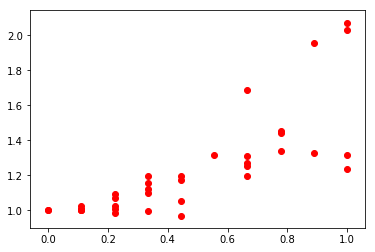

In [10]:
plt.scatter(X_test.flatten(), y_nn,c='r')  #y_pred
plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  #y_real

plt.show()

In [ ]:
plt.scatter(X_test.flatten(), y_pred.flatten(),c='r')  # y_pred/nn_pred
plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  # y_real
#plt.scatter(x,nn_real,c='b')  #nn_real

plt.show()

In [ ]:
display_points = 50

"""
#Evaluate real model
X_test = tModel.X_crossVal

#Real phi function
sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)
p_real, phi_real = analytic_functions.real_p(X_test[:,0], X_test[:,1], sigma_x, sigma_y)

tModel.y_crossVal = phi_real

#p_real = np.ravel(p_real)
#phi_real = np.ravel(phi_real)

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
#phi_pred = np.ravel(tModel.y_predicted)
phi_pred = tModel.y_predicted

d = 2 * np.pi * sigma_x * sigma_y
c_not = 1/d
p_pred = c_not * np.exp(-phi_pred)
"""

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
phi_pred = tModel.y_predicted
phi_real = tModel.y_crossVal
print("scores")

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(phi_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)

phi_real_sampled = phi_real[sample_points]
phi_pred_sampled = phi_pred[sample_points]
X_sampled = X_test[sample_points,:]

i = range(len(phi_pred_sampled))


for i, phi_real_display, phi_pred_display in zip(i, phi_real, phi_pred):
    print('xy {}, Real Phi {}, Predicted Phi {}'.format(X_test[i], phi_real_display, phi_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(1)
ax1 = Axes3D(fig1)
pred_phi_plot = Axes3D.scatter(ax1, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_pred)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('phi(x, y)_pred')

plt.show()

In [ ]:
fig2 = plt.figure(2)
ax2 = Axes3D(fig2)
real_phi_plot = Axes3D.scatter(ax2, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_real)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('phi(x, y)_real')

plt.show()

In [ ]:
fig3 = plt.figure(3)
ax3 = Axes3D(fig3)
pred_p_plot = Axes3D.scatter(ax3, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_pred)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('p(x, y)_pred')

plt.show()

In [ ]:
fig4 = plt.figure(4)
ax4 = Axes3D(fig4)
real_p_plot = Axes3D.scatter(ax4, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_real)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('p(x, y)_real')

plt.show()

In [ ]:
def real_derivatives(X, sigma_x, sigma_y):
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    first_order_dx = x1/(sigma_x**2)
    first_order_dy = x2/(sigma_y**2)
    second_order_dy = 1/(sigma_y**2)
    
    return first_order_dx, first_order_dy, second_order_dy

dx, dy, ddy = real_derivatives(X_test, sigma_x, sigma_y)

In [ ]:
dx, dy, ddy = analytic_functions.real_derivatives(tModel.X_crossVal, sigma_x, sigma_y)

#for i in range(len(dx)):
 #   print('dx {}, dy {}, ddy {}'.format(dx[i], dy[i], ddy[i]))